In [2]:
from IPython.display import Image

Protocol used by Albertas to make this data: https://benchling.com/anavickas/f/lib_VNejBHt6-protocols/prt_2Bkfh557-meripseq/edit

HIV-1 IIIB Virus 
https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607

## Preprocessing

We've started analyzing from raw `fastq` files. Then, we trimmed `NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA` sequence from each reads using `cutadapt` ([see documents](https://cutadapt.readthedocs.io/en/stable/)). Trimmed `fastq` files aligned to Human genome `gencode.v28.annotation.gtf` using STAR aligner. In addition, unmmaped reads for each `fastq` file saved to a new `fastq` file to align seprately to HIV genome. Therefore, HIV genome indices created by changing sequence provided by Judd to `.fa` format using `bowtie2` ([see documents](https://github.com/BenLangmead/bowtie2)).

For downstream analysis of meRIPSeq experiment, all `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

## Peakcalling 

We are using RADAR package for meRIP data analysis ([see RADAR manual](https://scottzijiezhang.github.io/RADARmanual/workflow.html)). It will run over bam files for each treatment: . 
- 'METTL14'
- 'METTL3'
- 'Virma'
- 'WTAP'

Here, we have this `run_radar` function which run RADAR that take bam files as input and give bed file contain m6A peaks that pass the cutoffs. 

In [ ]:
library("RADAR")
run_radar <- function(enz, gtf,species='human', cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
    radar <- normalizeLibrary(radar, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctrl","Treated"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    
    write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
}

> To assess the pattern of variation of the MeRIP-seq data, we can plot the heatmap of methylation level (represented by the normalized IP read counts adjusted for expression level).



At this point, one can proceed to the next step to report the significantly differentially methylated bins to genomic location.

### Non-Treated vs. METTL14-Treatment 
The PCA plot here is not reasonable where both treated and non-treated data for sample 23 are not seprated.

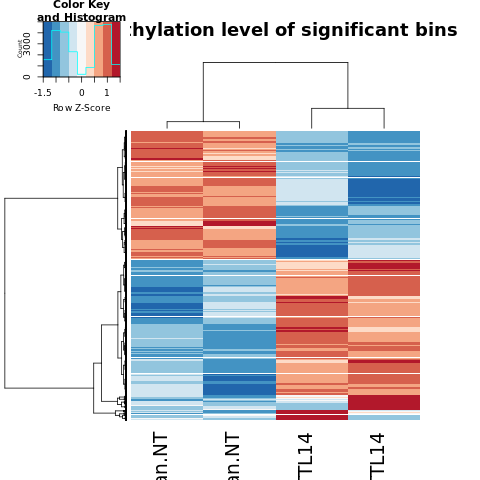

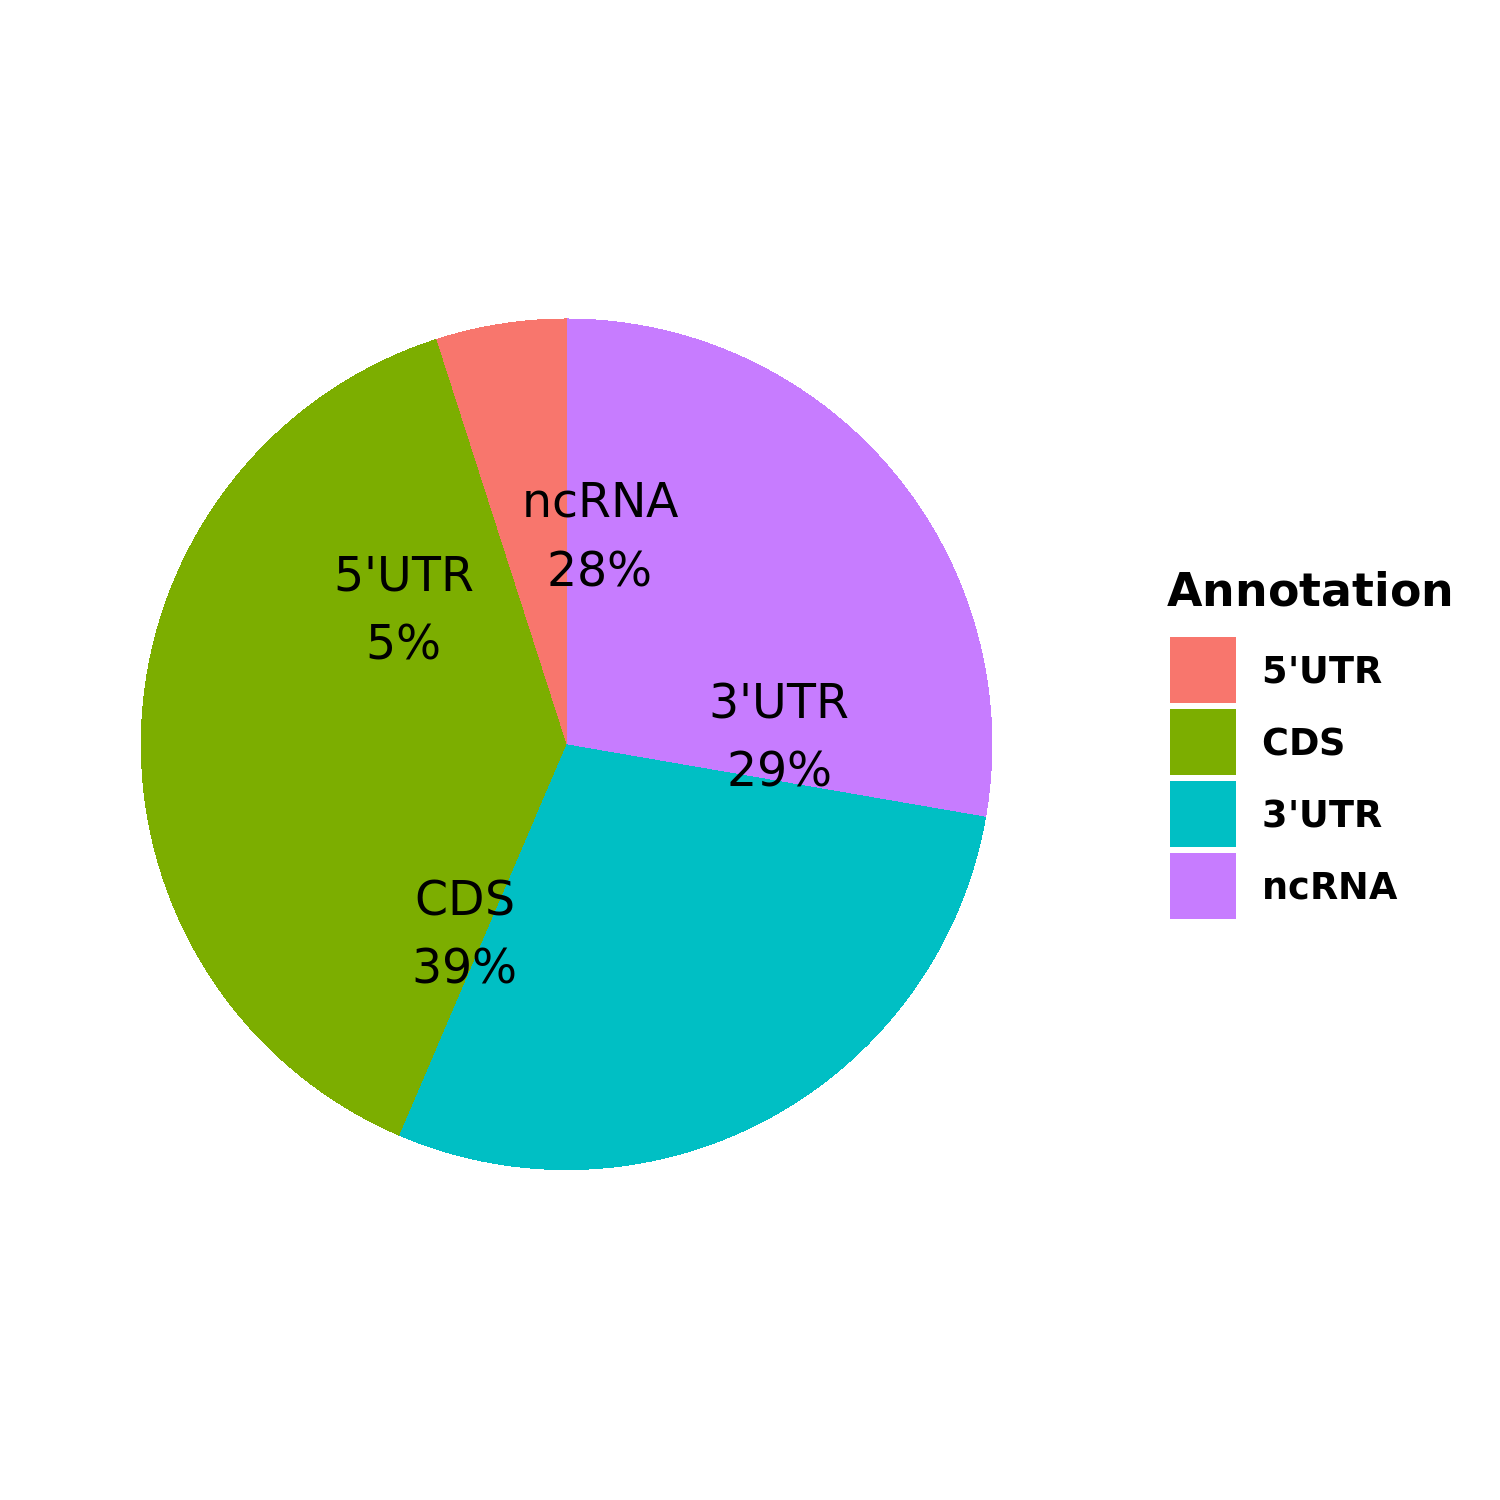

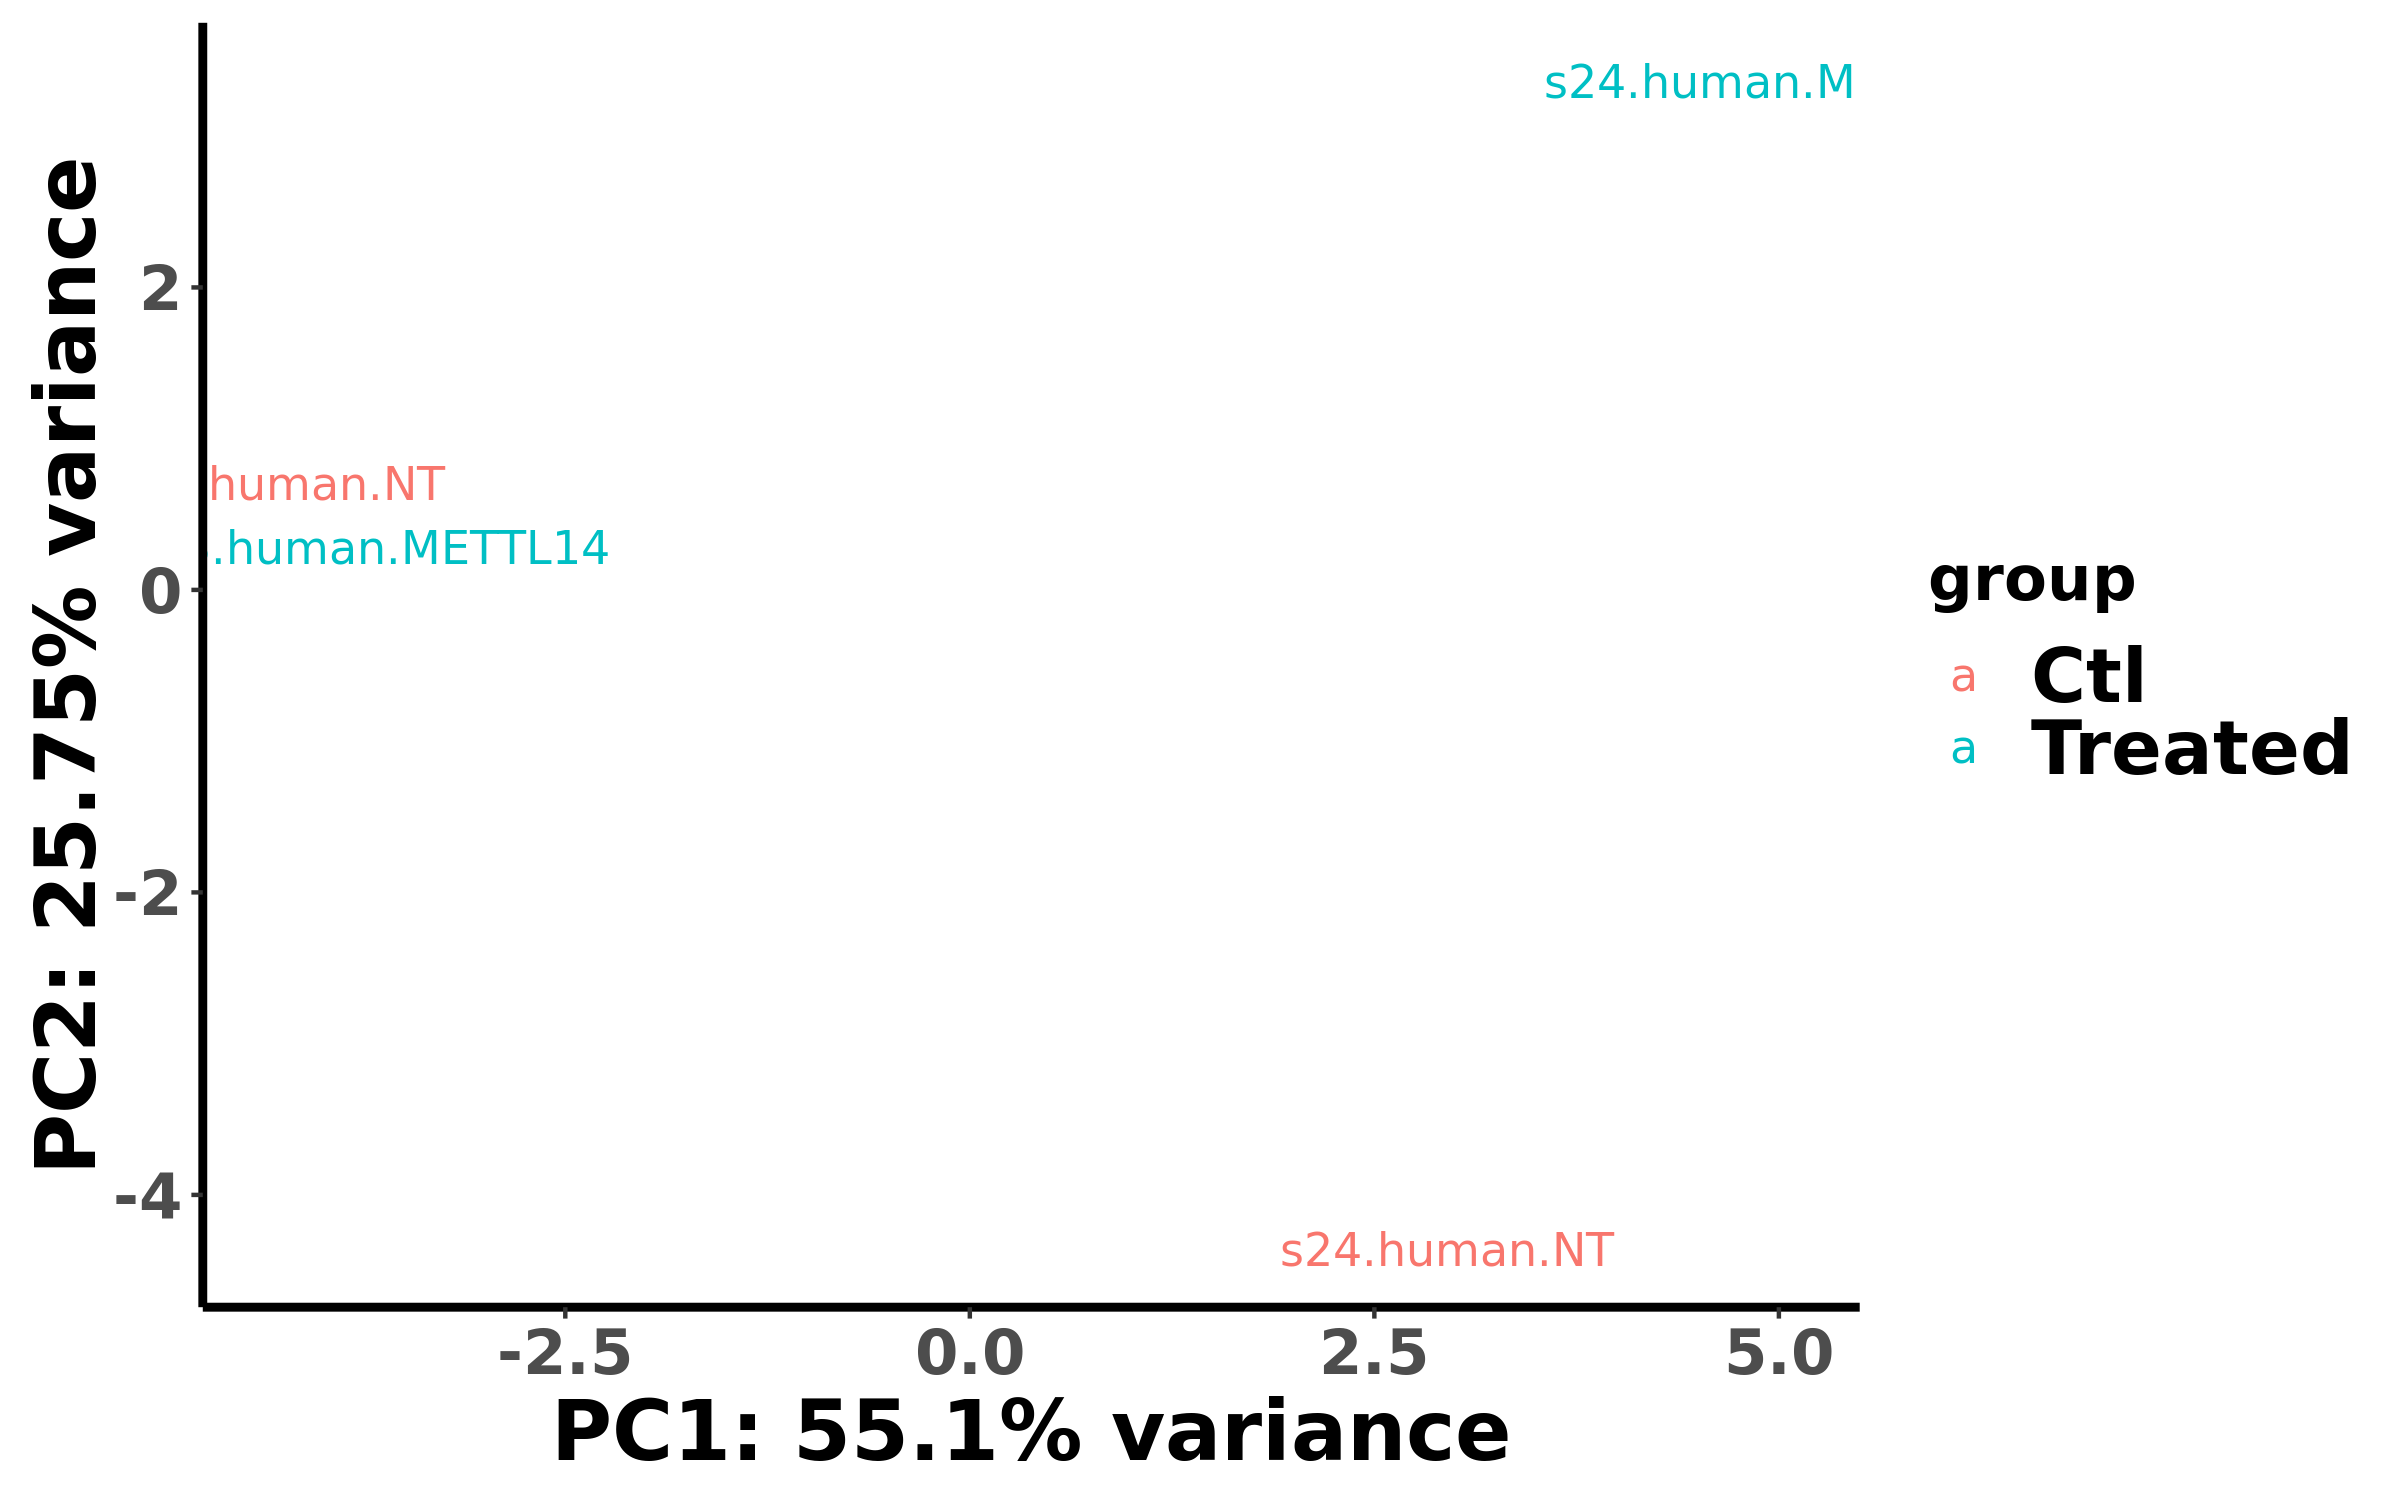

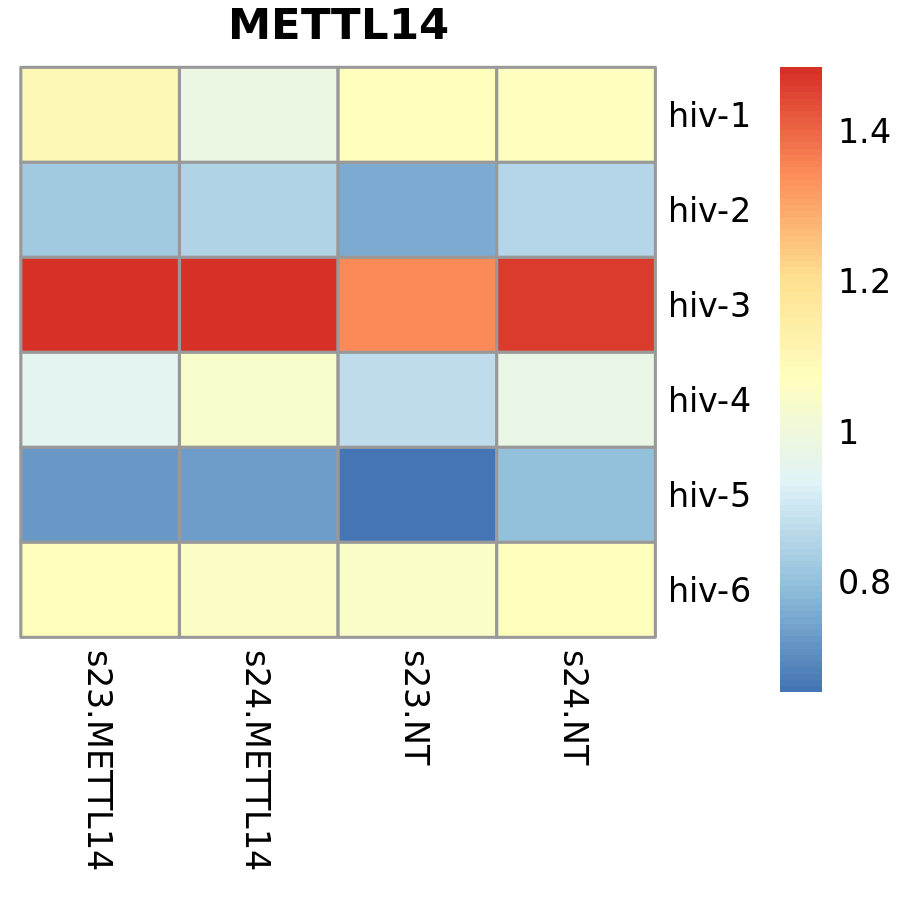

In [40]:
enz = 'METTL14'
img0 = Image('plots/radar.'+enz+'.Heatmap.png',width=400)
img1 = Image('plots/radar.'+enz+'.Distribution.png',width=400)
img2 = Image('plots/radar.'+enz+'.PCA.png',width=400)
img3 = Image('plots/hiv.'+enz+'_Heatmap.png',width=400)
display(img0, img1, img2,img3)

### Non-Treated vs. METTL3-Treatment 

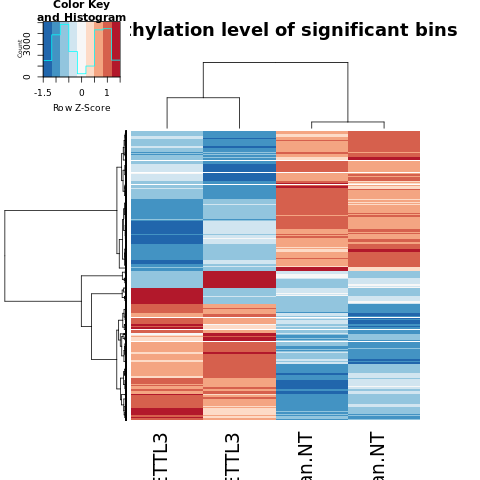

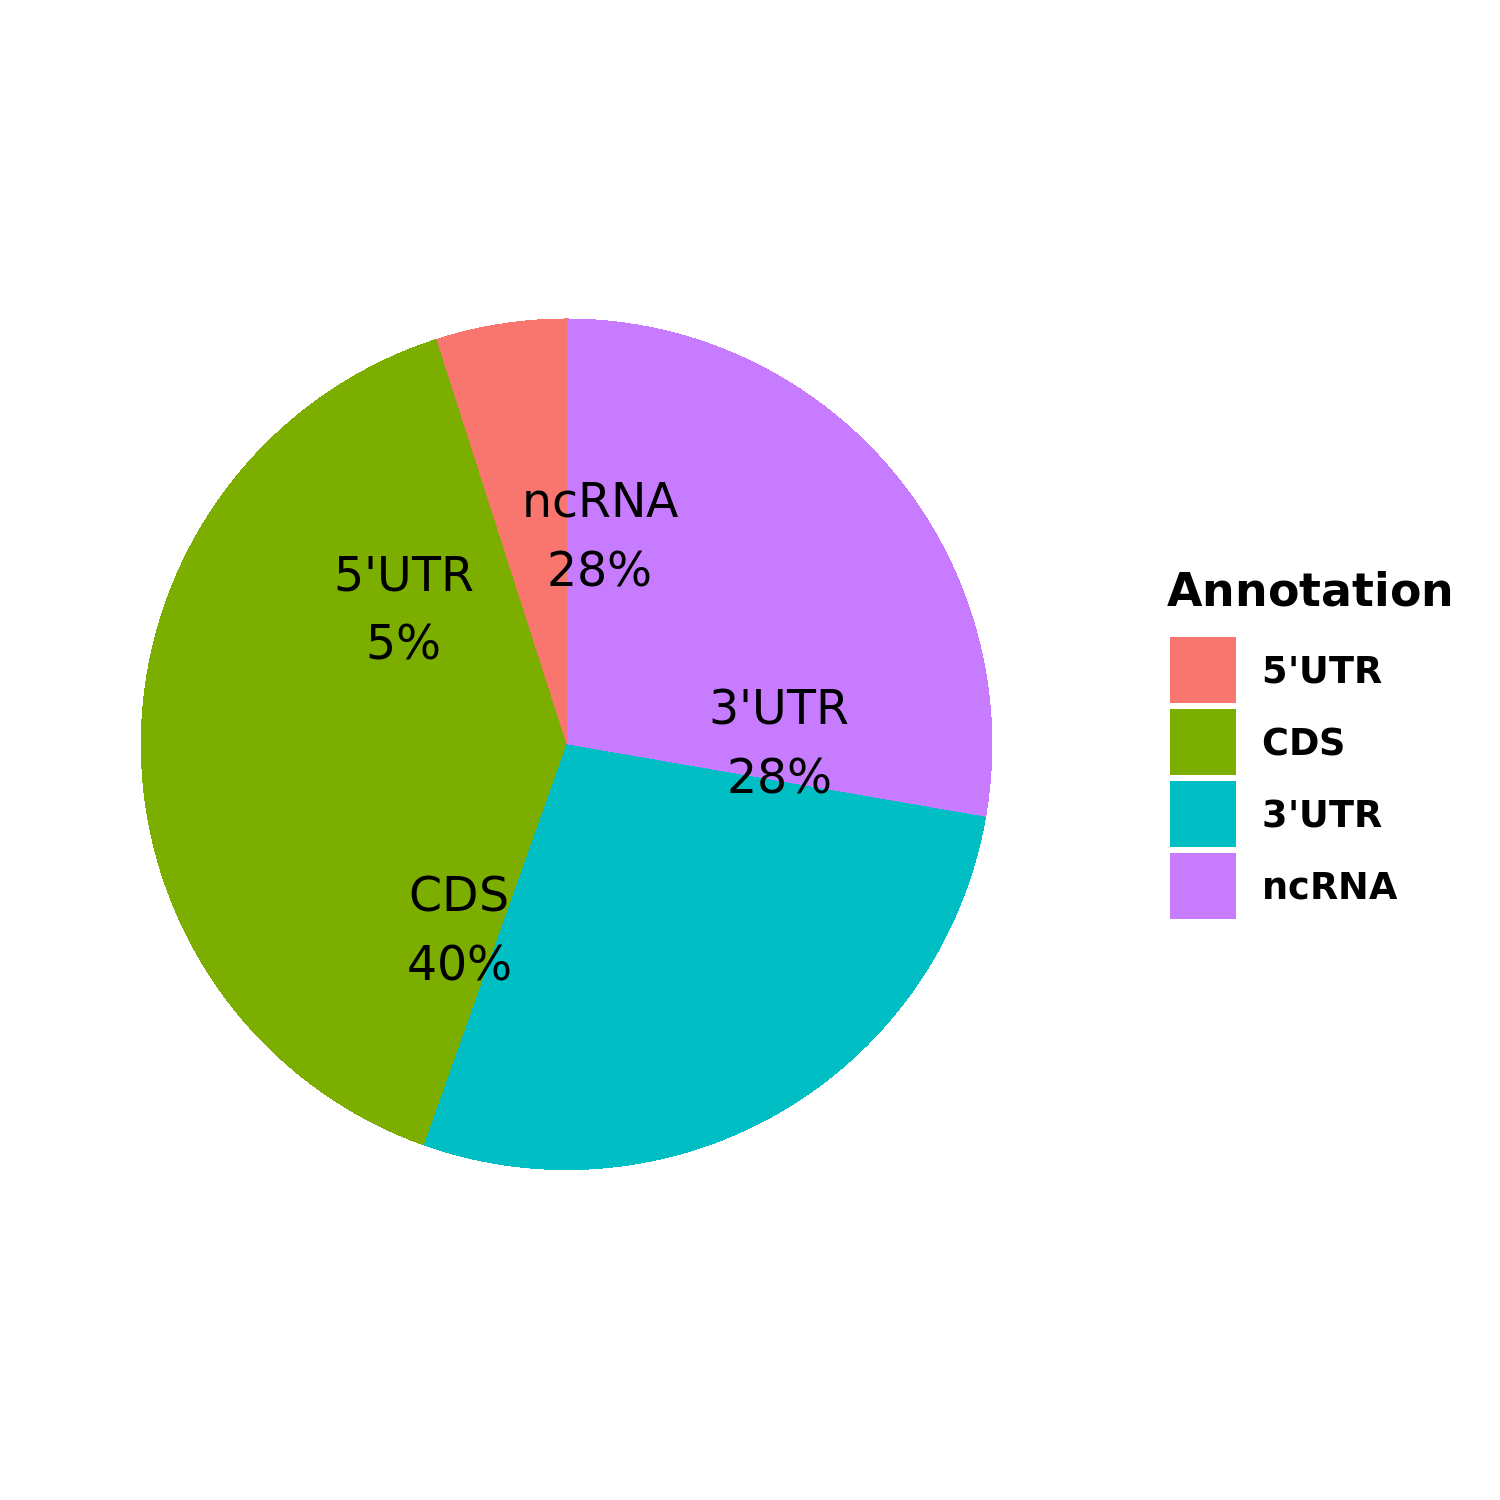

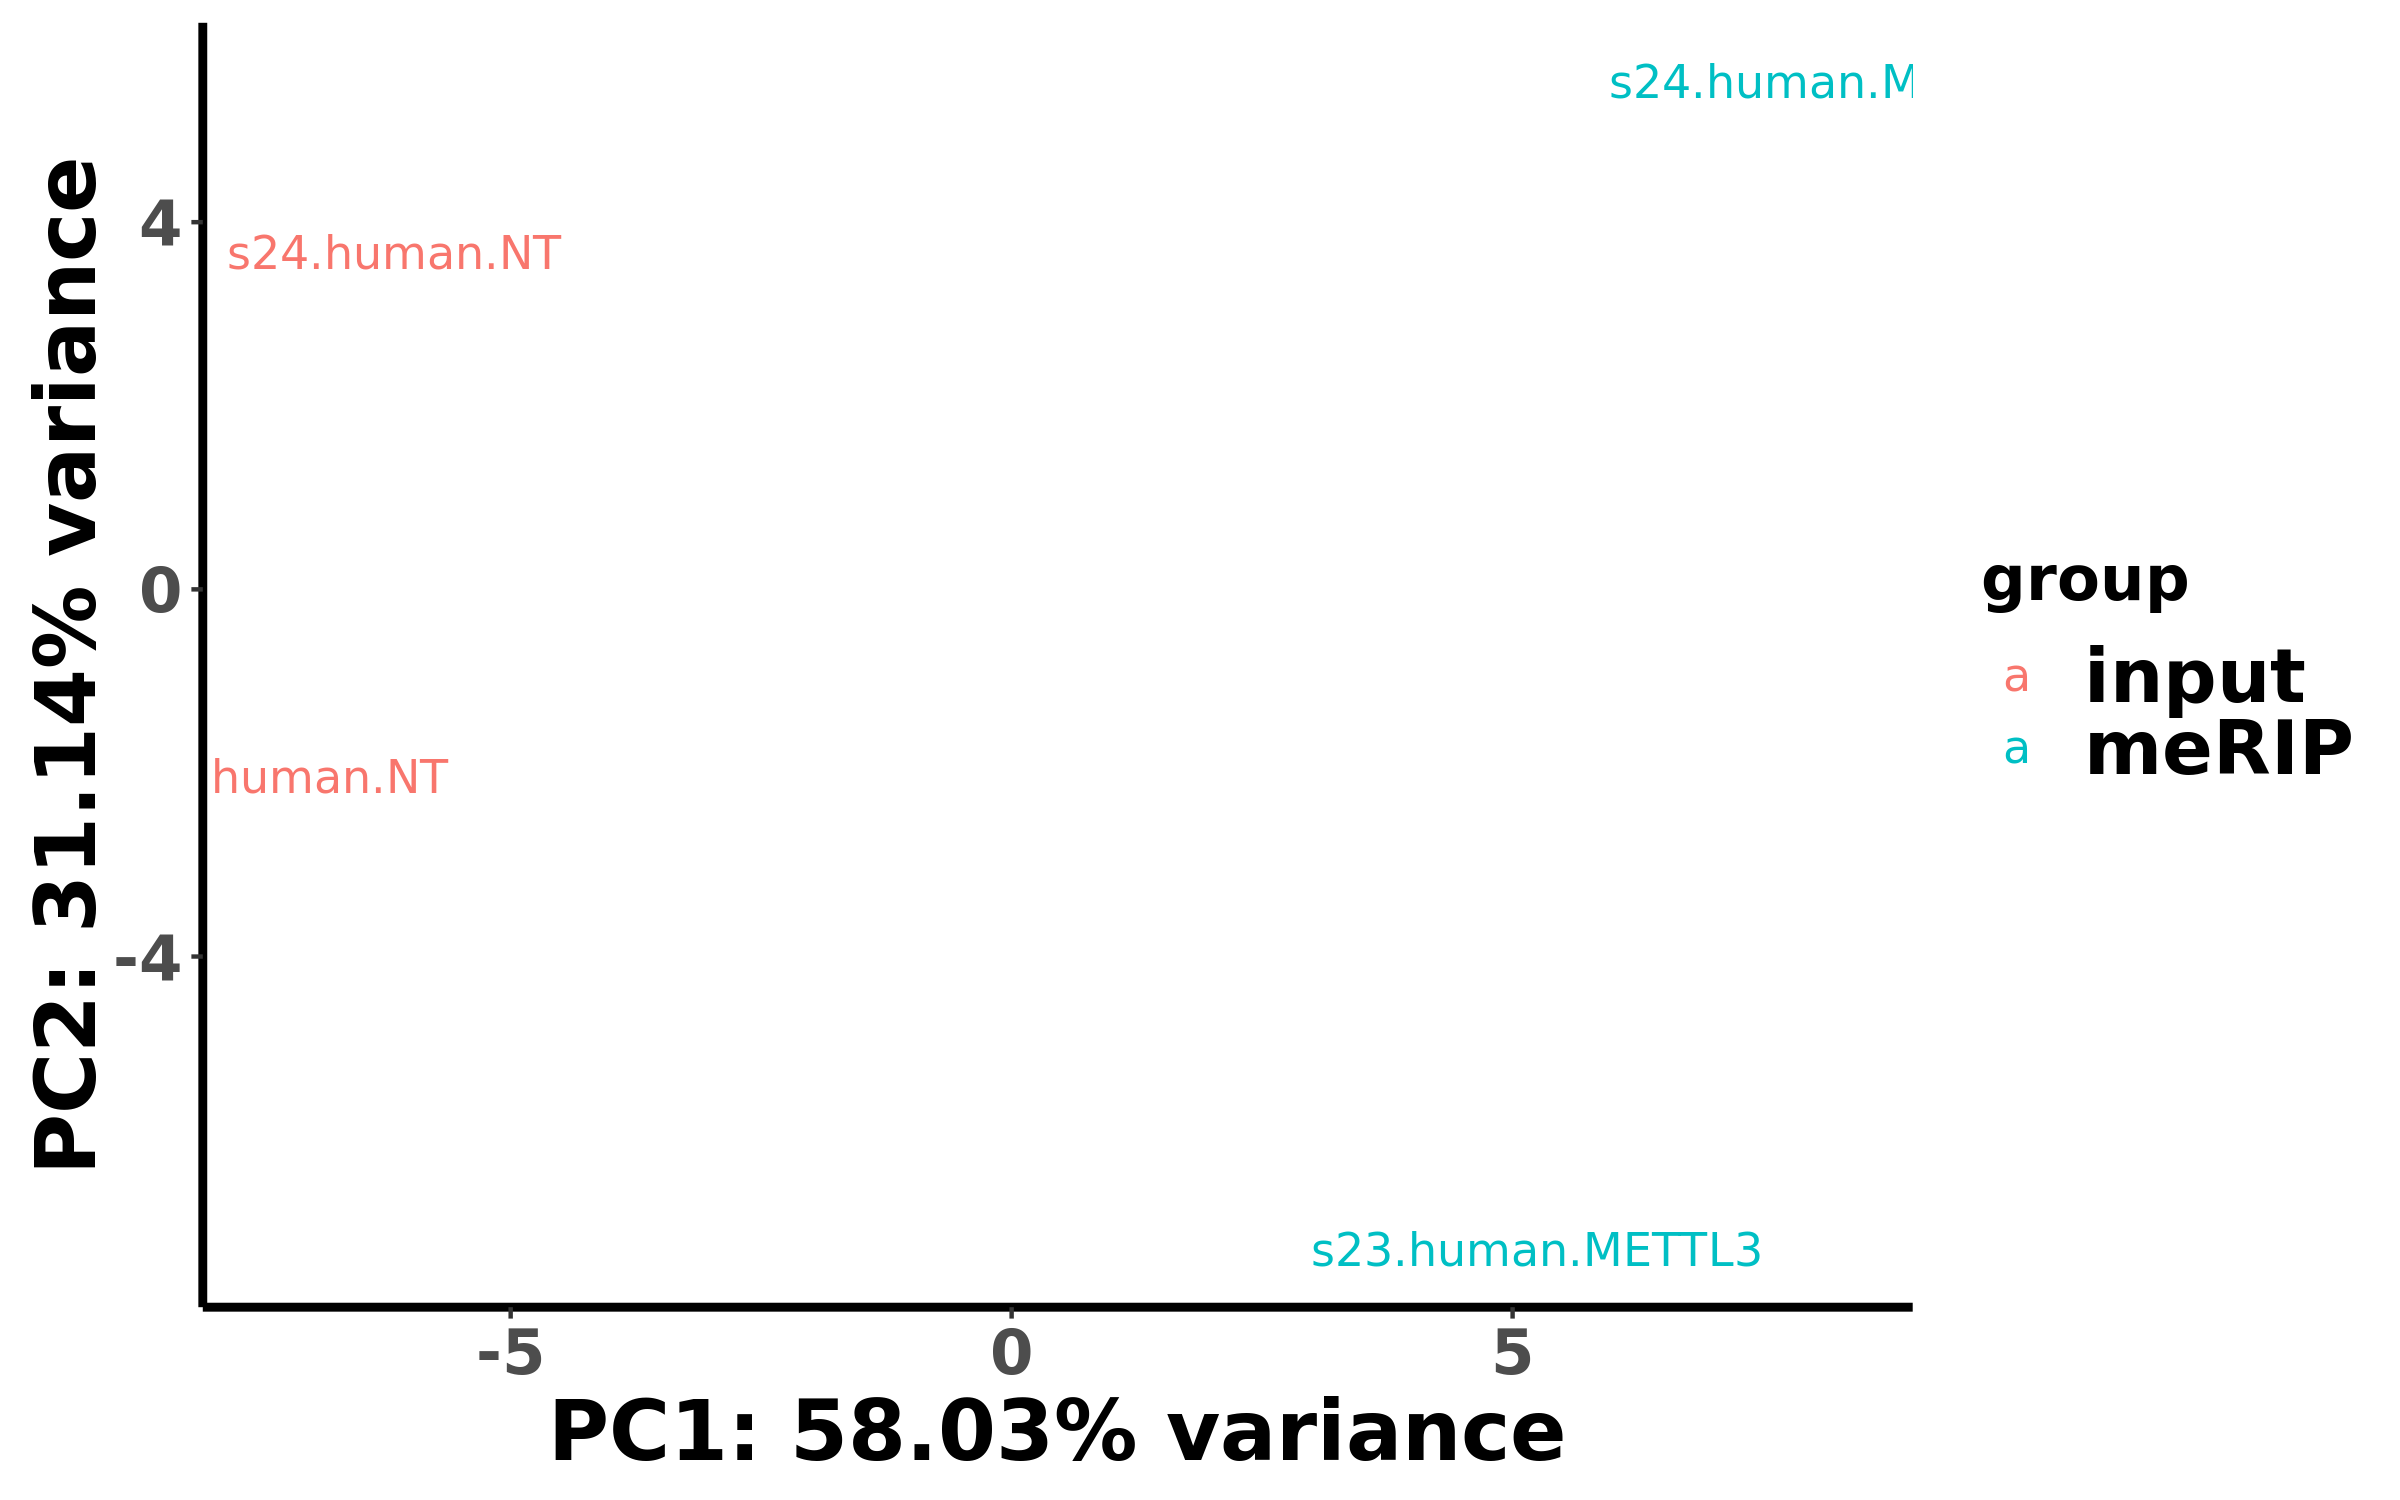

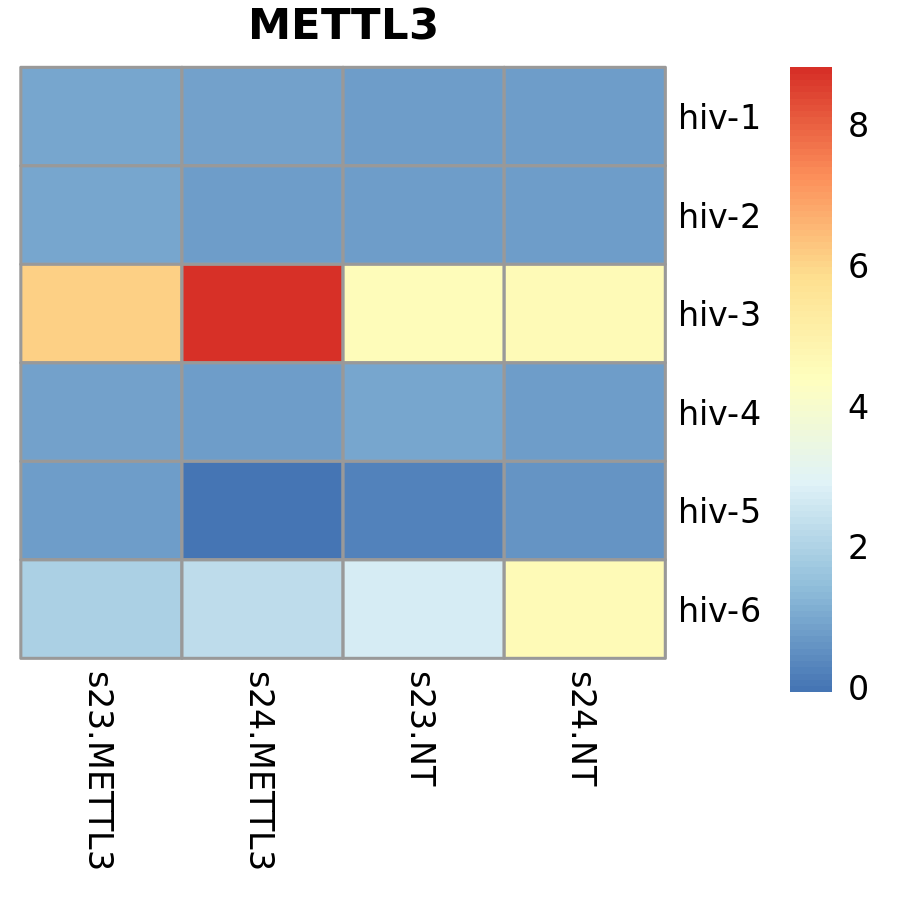

In [41]:
enz = 'METTL3'
img0 = Image('plots/radar.'+enz+'.Heatmap.png',width=400)
img1 = Image('plots/radar.'+enz+'.Distribution.png',width=400)
img2 = Image('plots/radar.'+enz+'.PCA.png',width=400)
img3 = Image('plots/hiv.'+enz+'_Heatmap.png',width=400)
display(img0, img1, img2,img3)

### Non-Treated vs. Virma-Treatment  

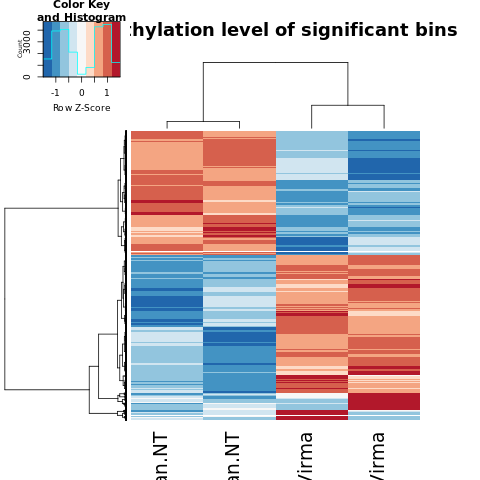

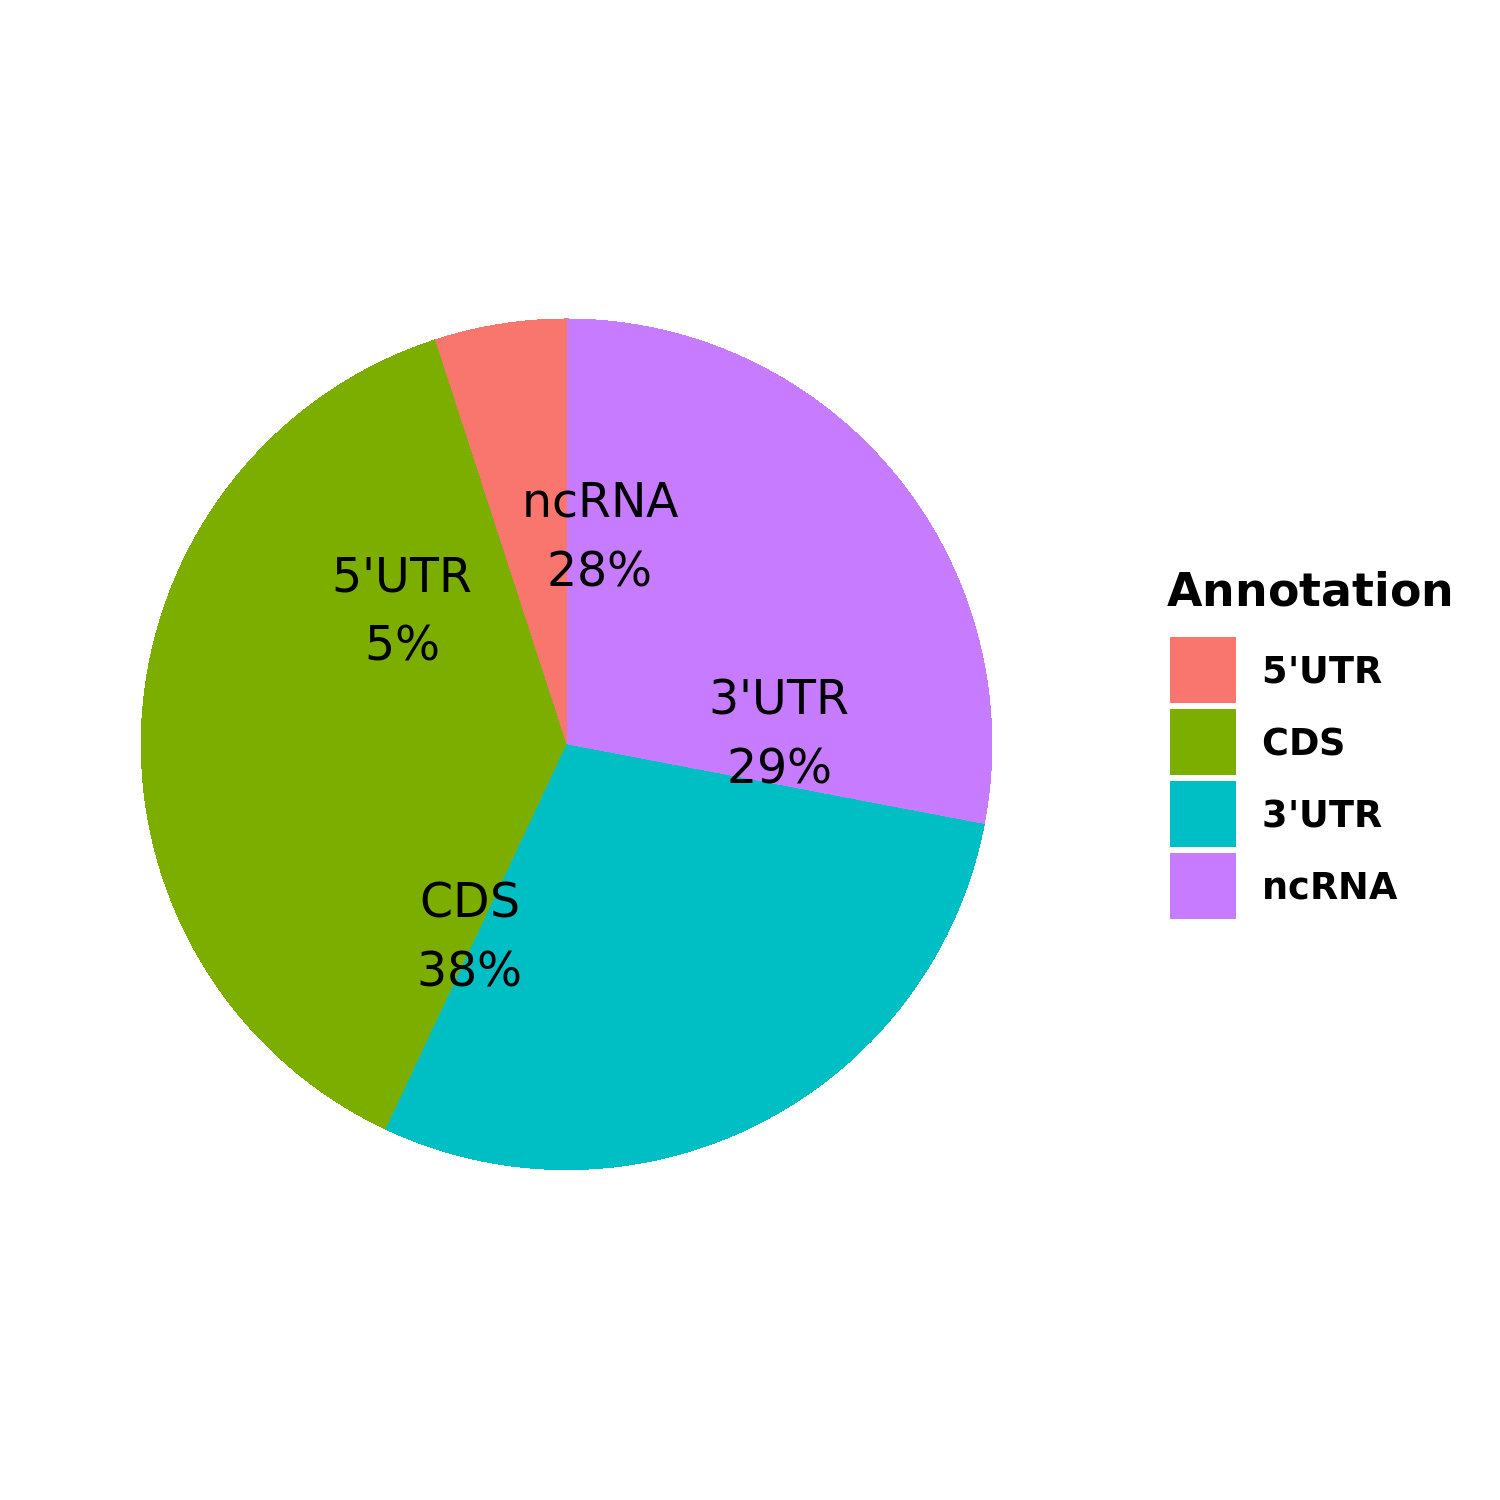

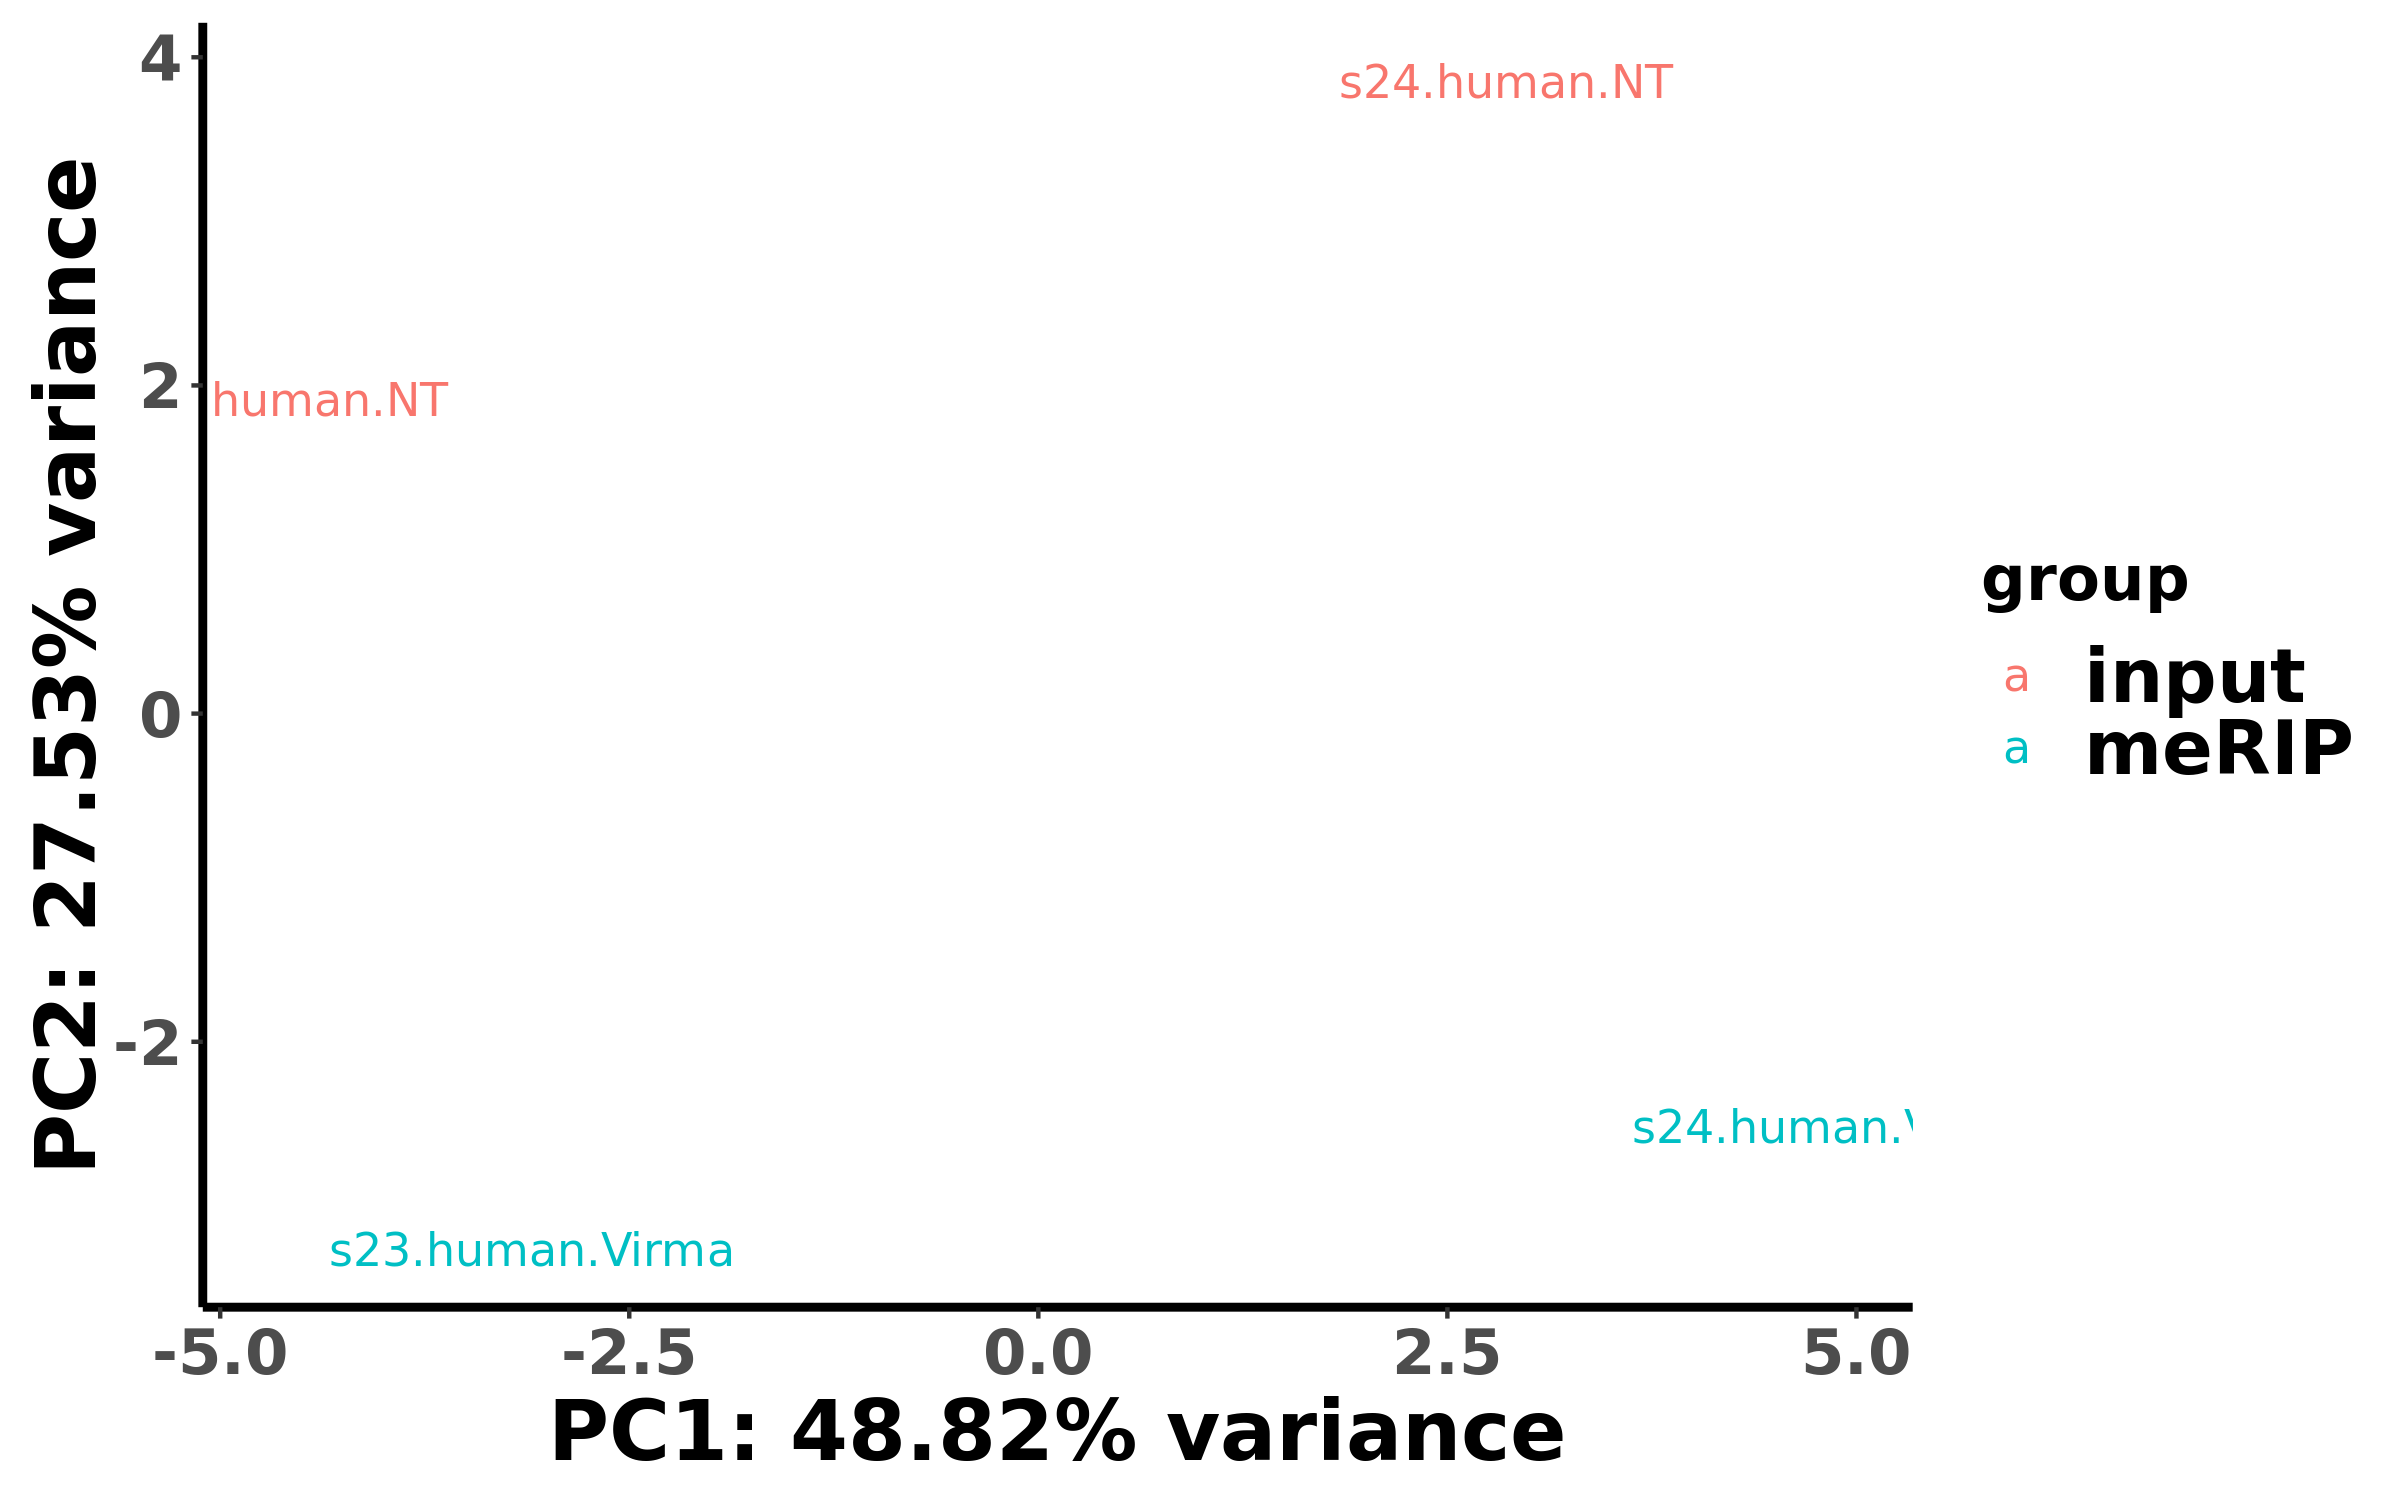

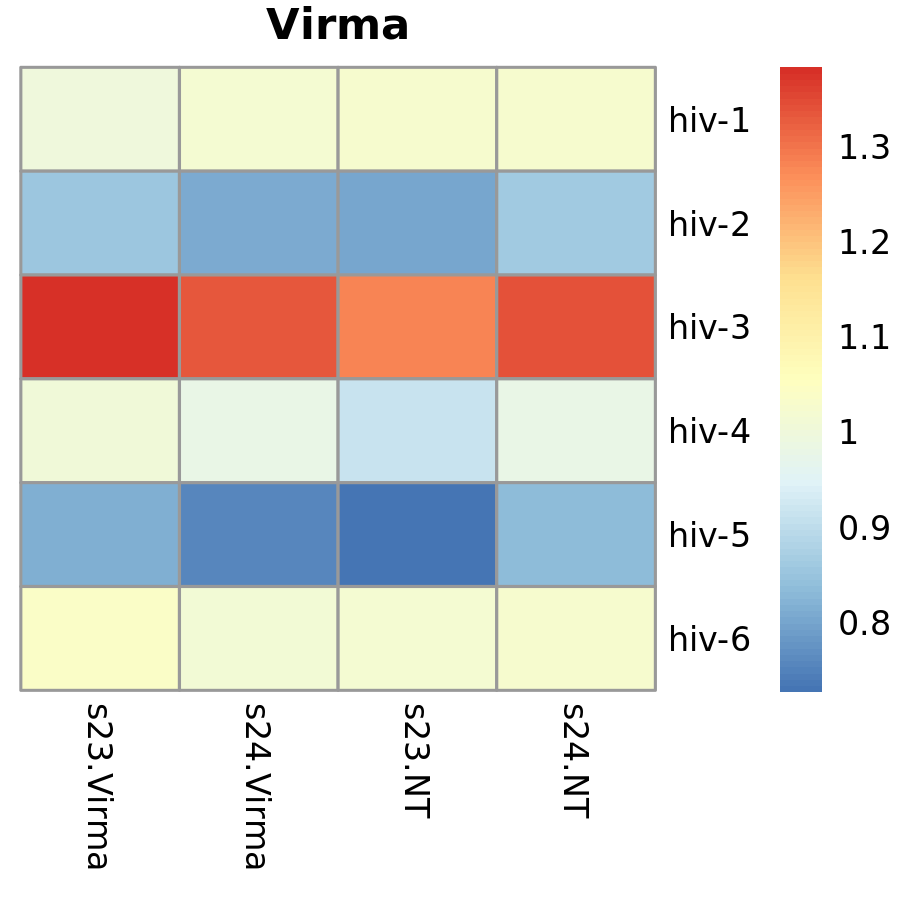

In [42]:
enz = 'Virma'
img0 = Image('plots/radar.'+enz+'.Heatmap.png',width=400)
img1 = Image('plots/radar.'+enz+'.Distribution.png',width=400)
img2 = Image('plots/radar.'+enz+'.PCA.png',width=400)
img3 = Image('plots/hiv.'+enz+'_Heatmap.png',width=400)
display(img0, img1, img2,img3)

### Non-Treated vs. WTAP-Treatment 

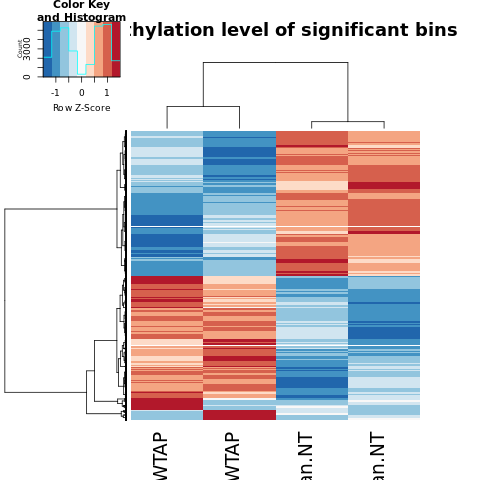

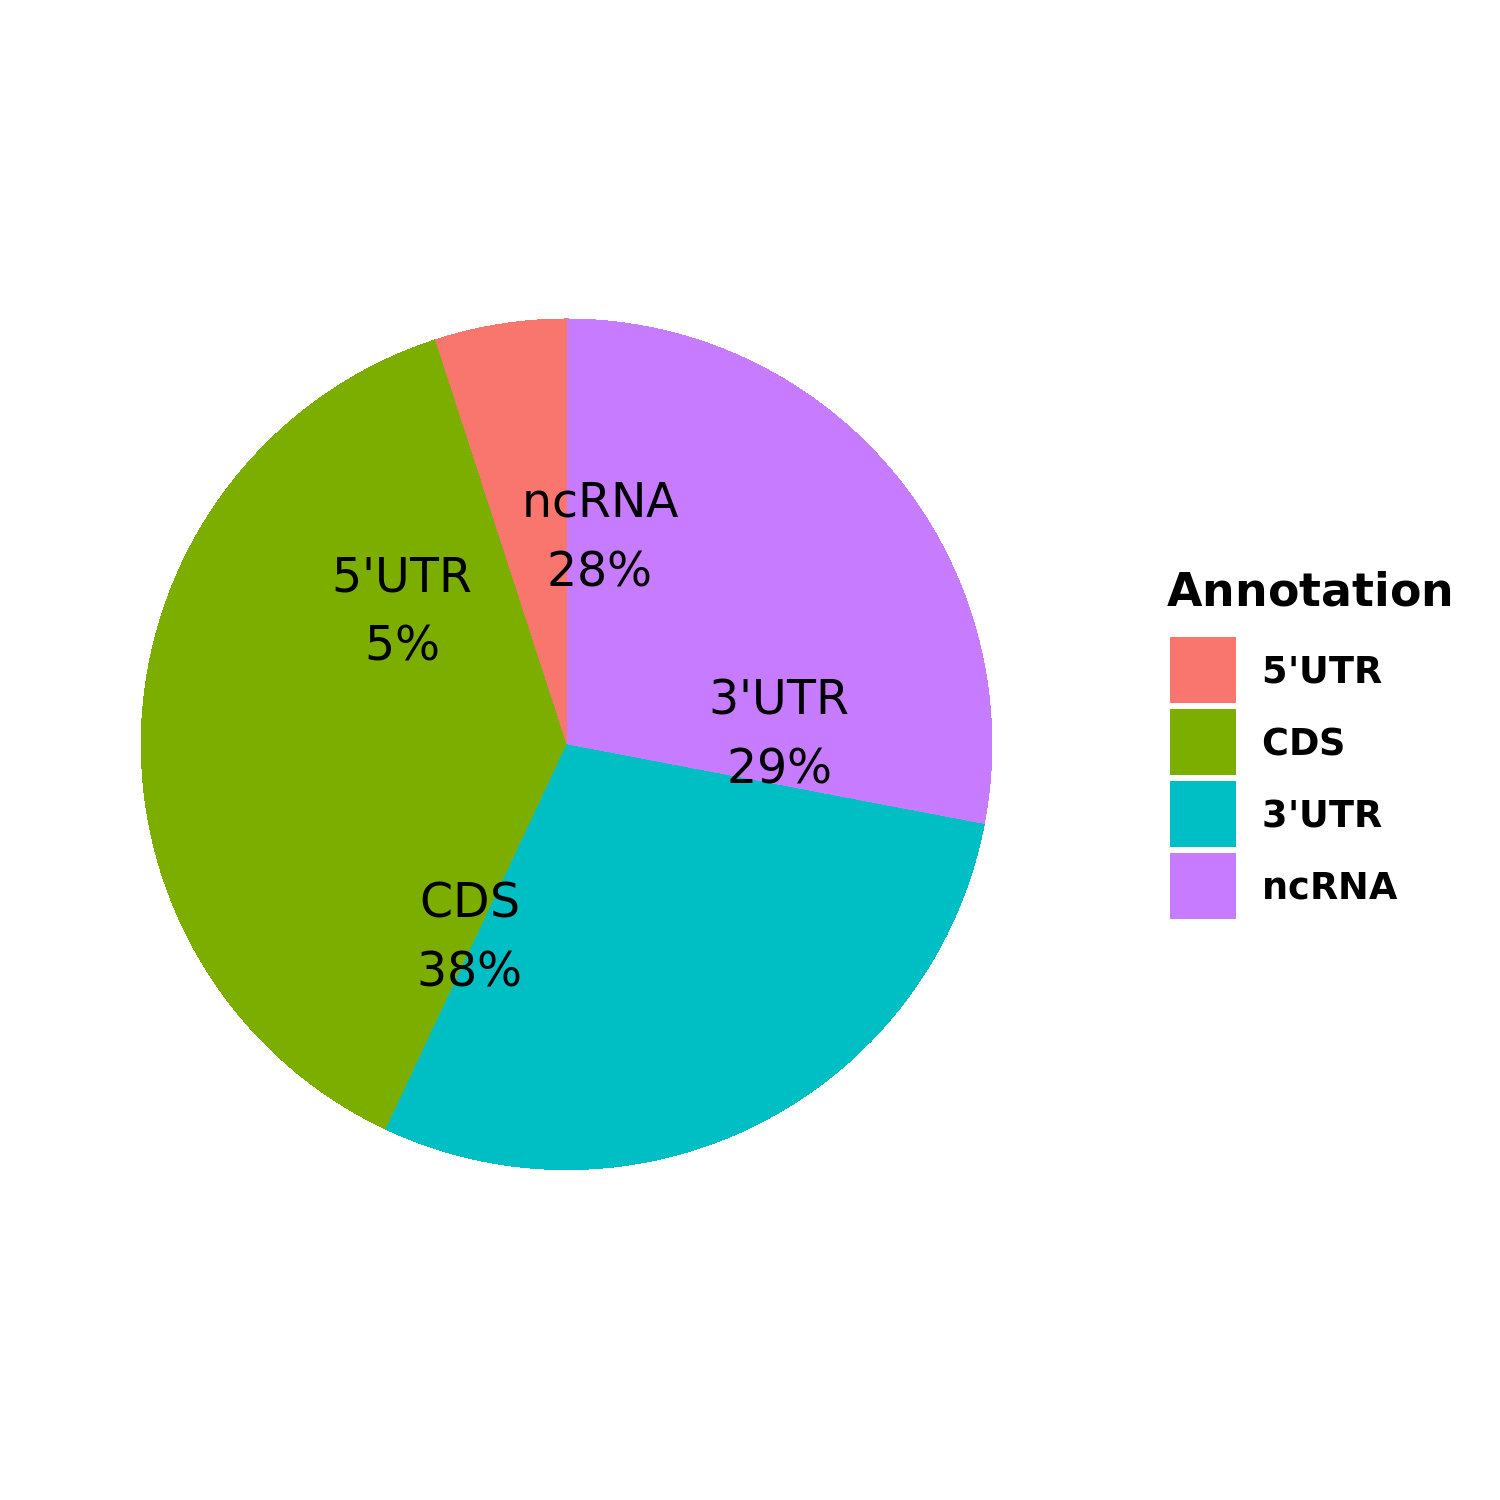

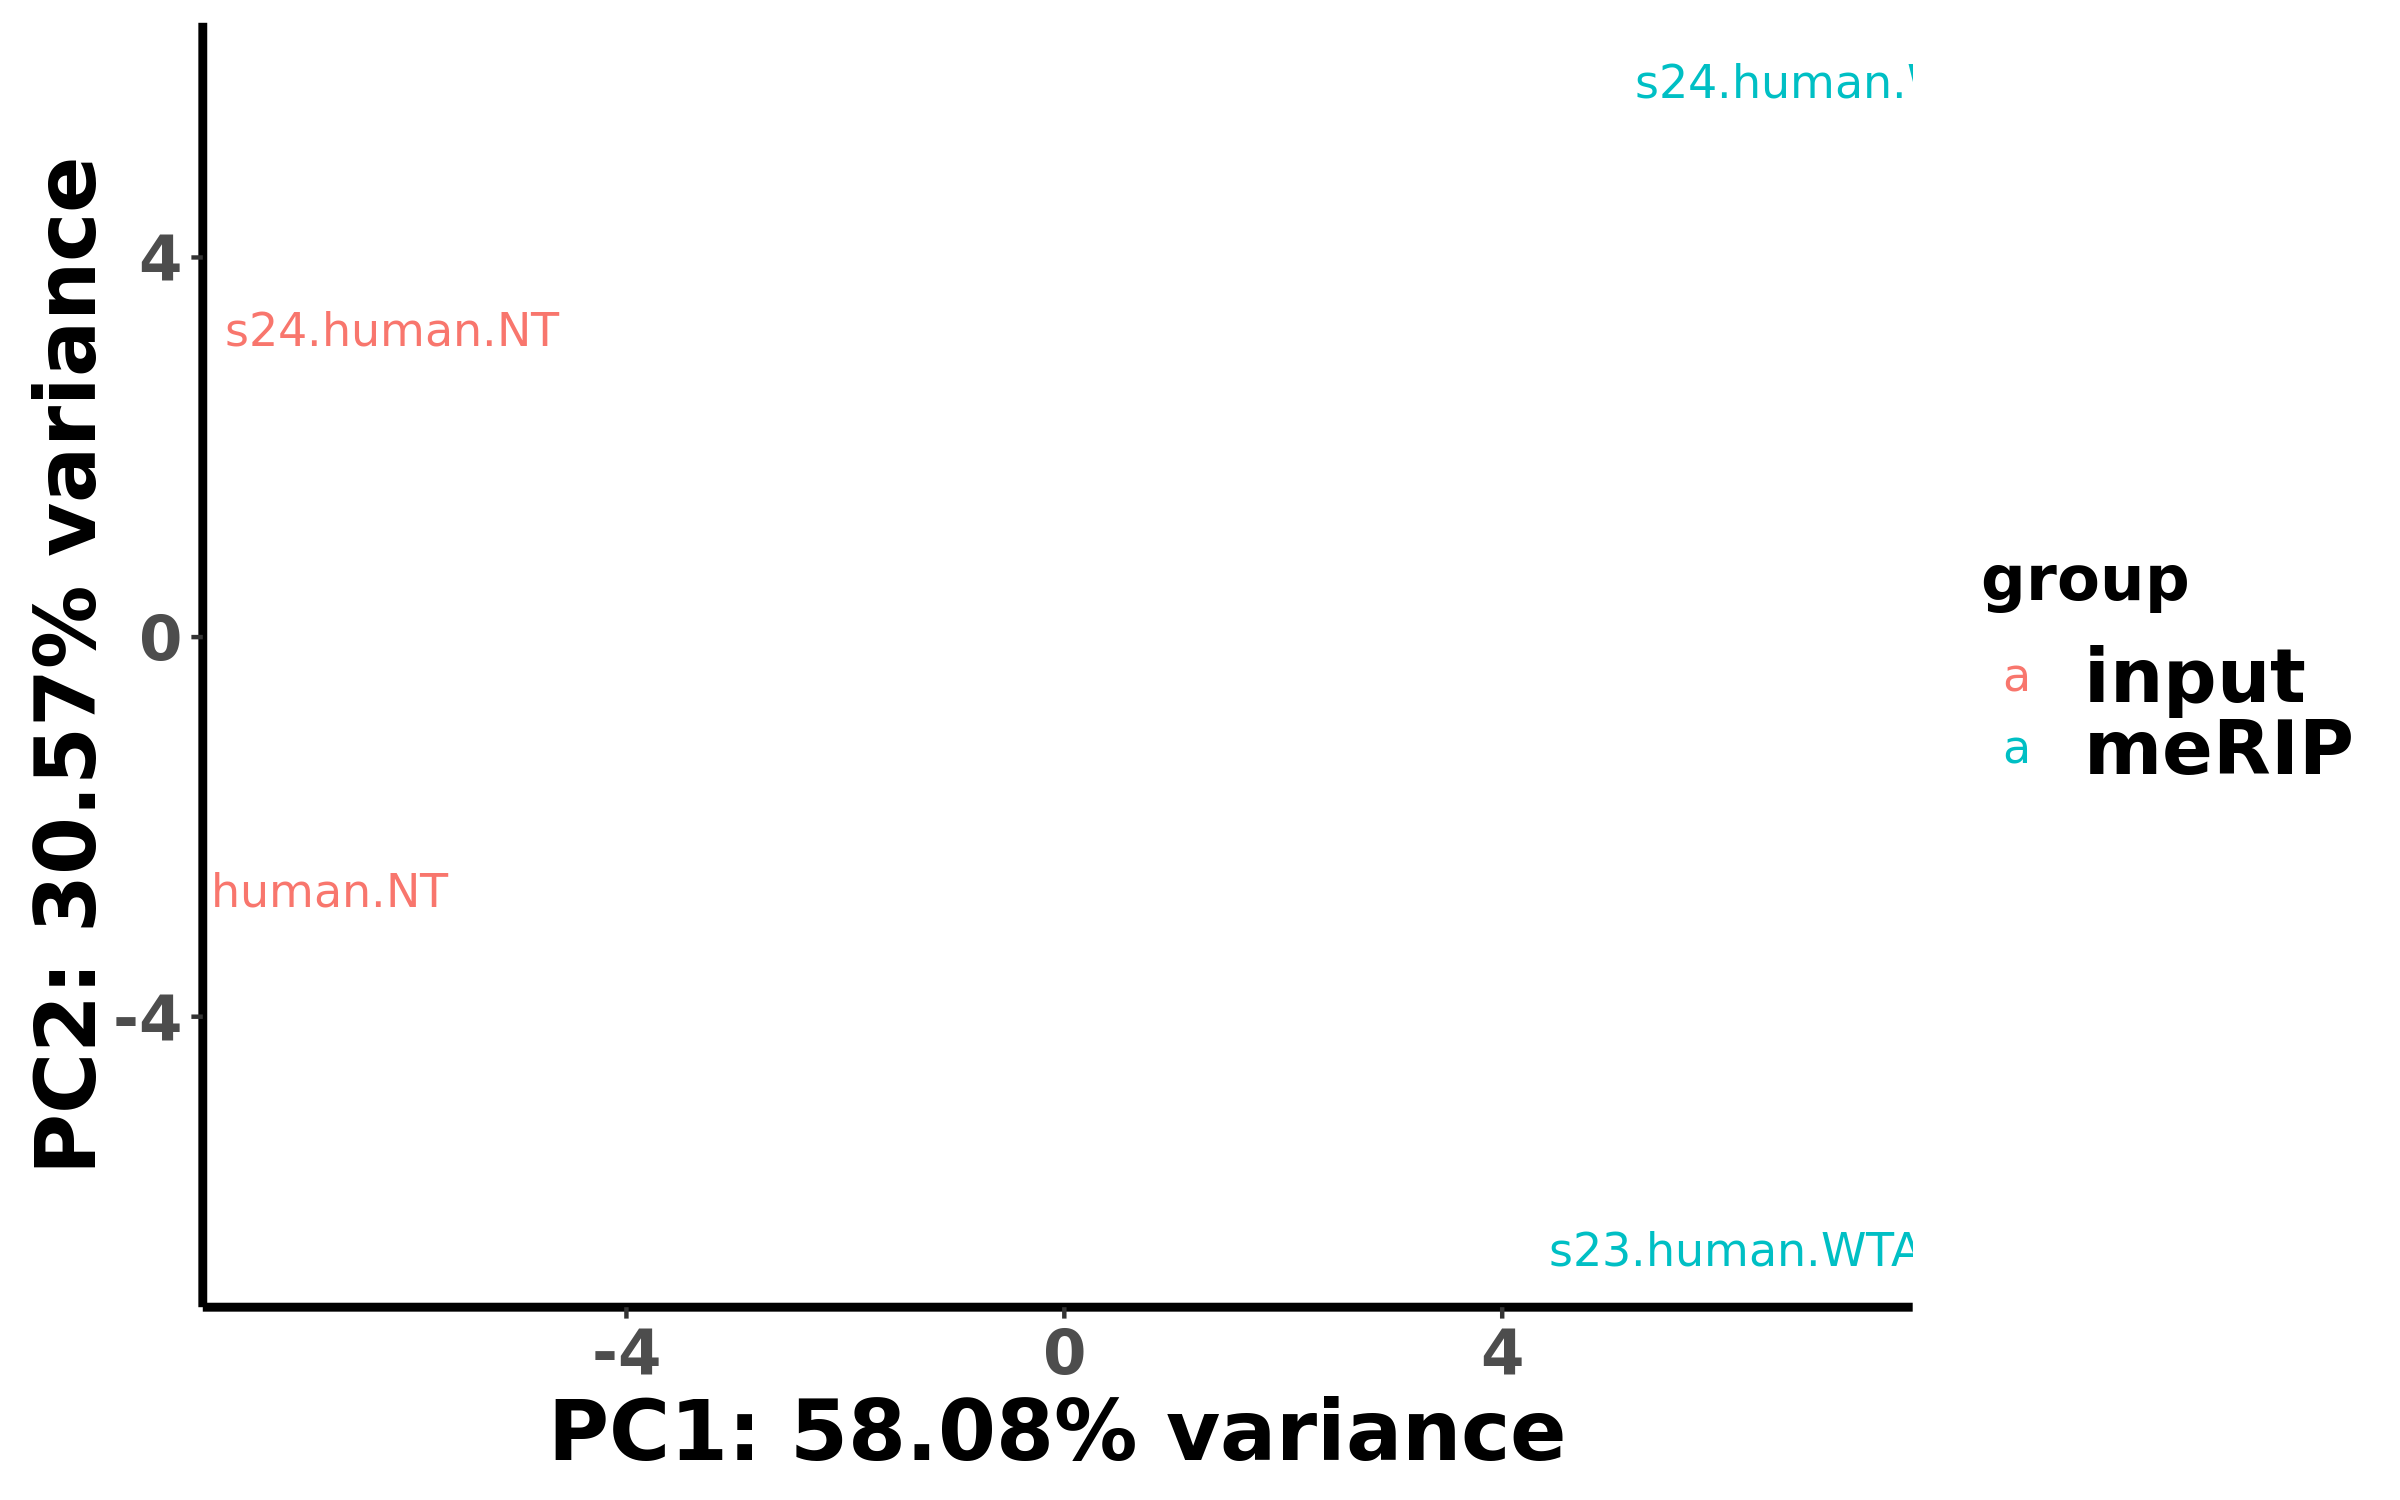

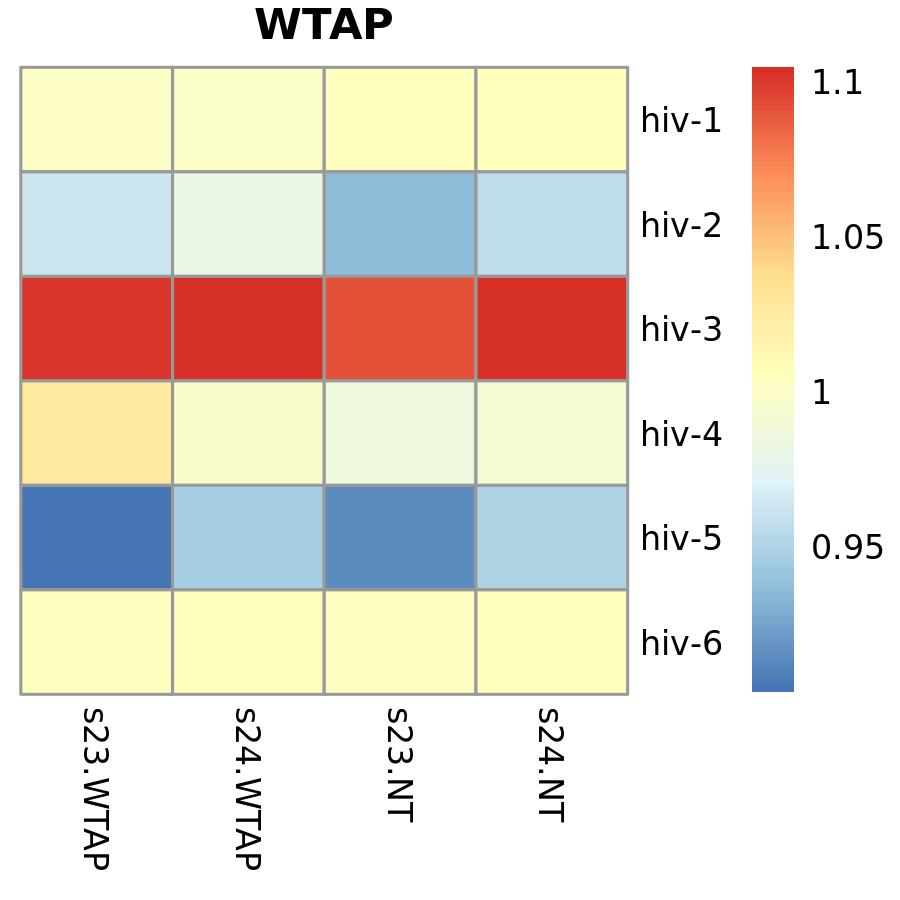

In [43]:
enz = 'WTAP'
img0 = Image('plots/radar.'+enz+'.Heatmap.png',width=400)
img1 = Image('plots/radar.'+enz+'.Distribution.png',width=400)
img2 = Image('plots/radar.'+enz+'.PCA.png',width=400)
img3 = Image('plots/hiv.'+enz+'_Heatmap.png',width=400)
display(img0, img1, img2,img3)

# Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). Here we compare Input and IP 

In [ ]:
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.m6A.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','control', 'results.rds', sep='/'))

As expected, there is high density of methylation peaks at end of CDS. 

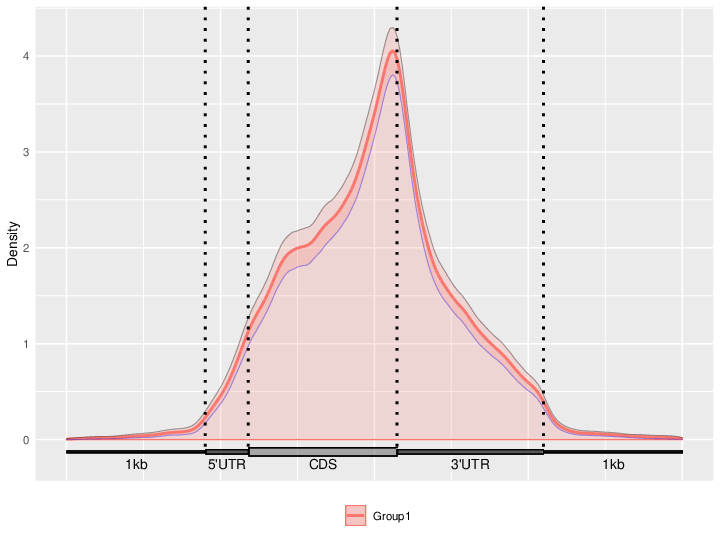

In [52]:
img = WImage(filename='plots/control_mrna_test.pdf', resolution=90) # bigger
img

## Motif analysis 

We've anlyzed only non-trated samples here. We've used [FIRE](https://tavazoielab.c2b2.columbia.edu/FIRE/) to compare m6A vs. input peaks for `[AG]GAC` and `[AGT][AG]AC[ACT]` motifs. The result shows significant presence of these motifs as expected. 

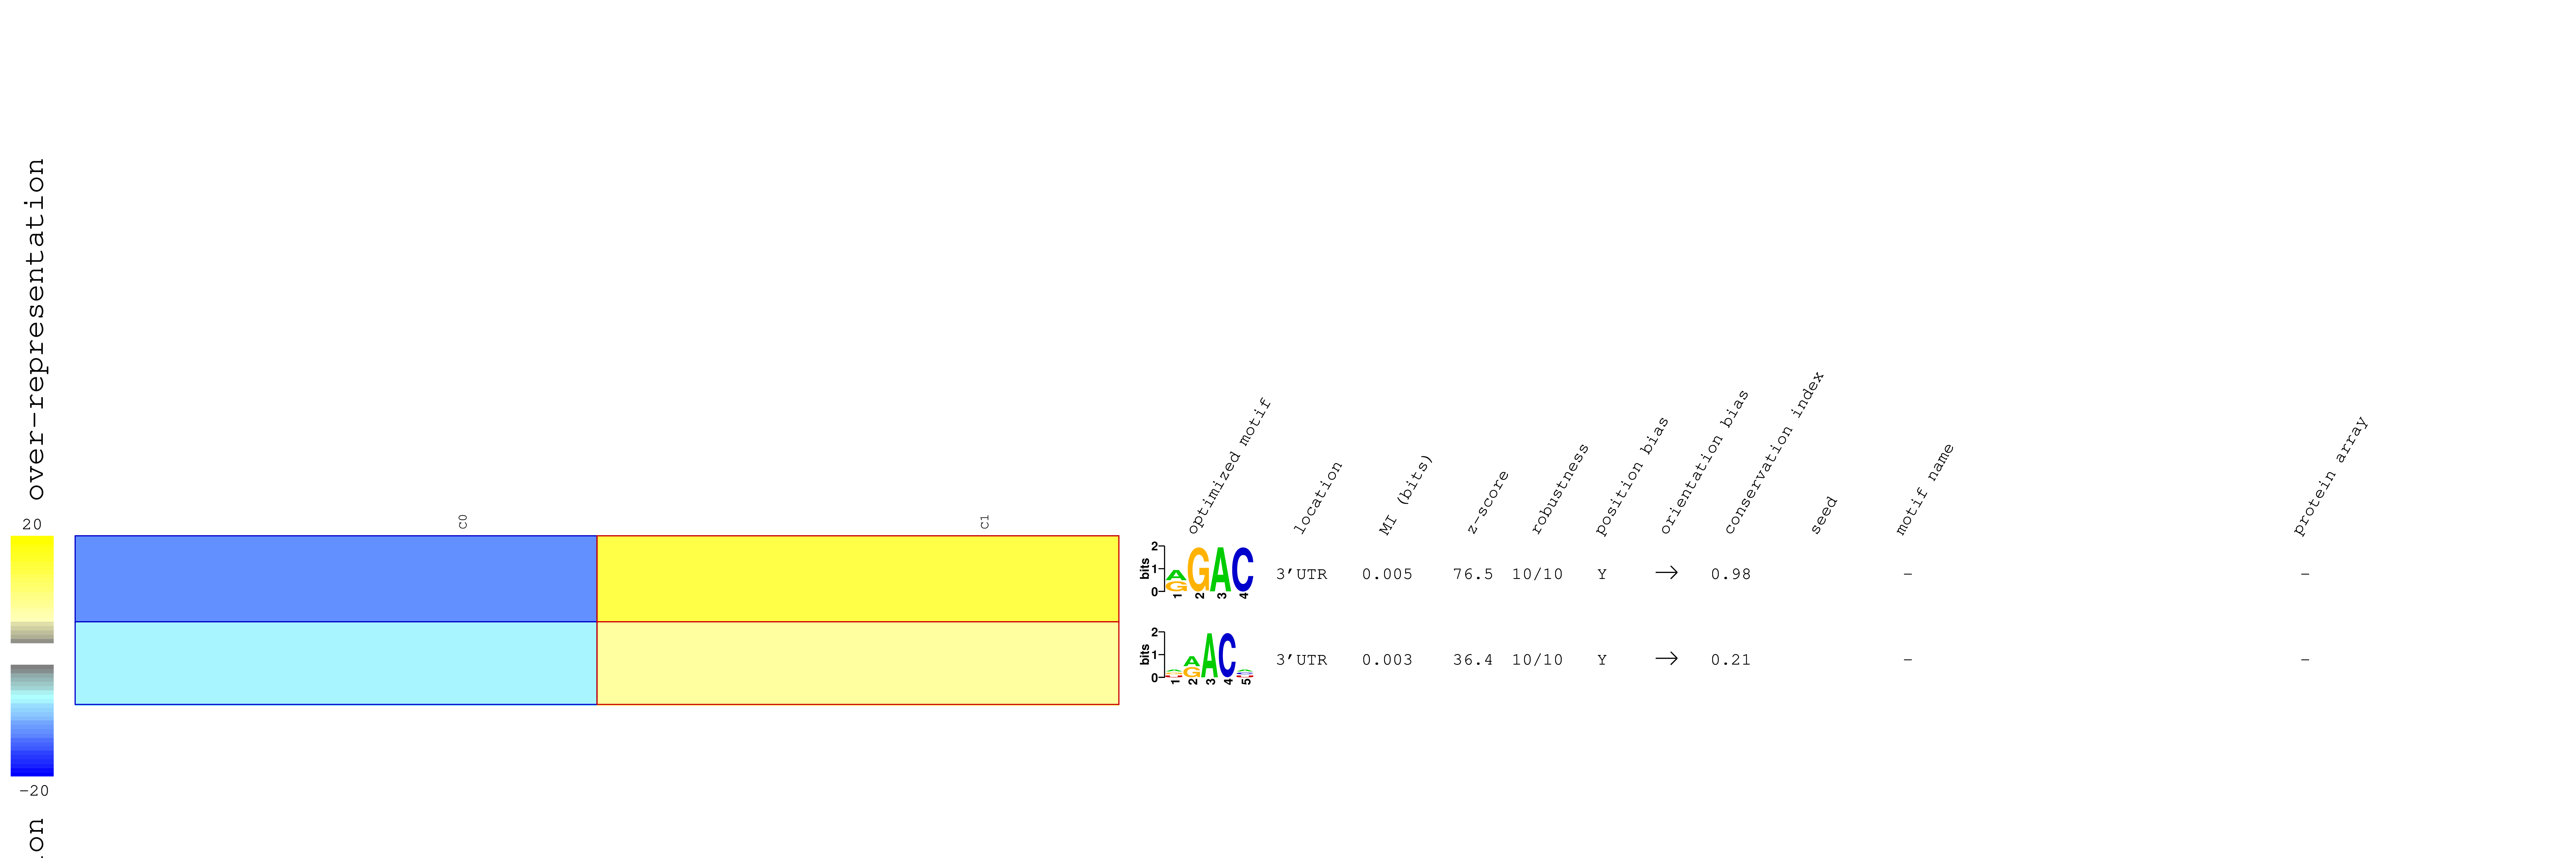

In [54]:
img = WImage(filename='exomepeak/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.summary.pdf', 
             resolution=500) # bigger
img

## Similar paper 
> [Dynamics of the human and viral m6 A RNA methylomes during HIV-1 infection of T cells](https://www.nature.com/articles/nmicrobiol201611.pdf?proof=t)
[GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74016)

It might be informative to analyze data in this paper using above pipeline. However, they’re using [pLAI.2 HIV](https://aidsreagent.org/reagentdetail.cfm?t=molecular_clones&id=47) but Judd have used [HIV-1 IIIB Virus](https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607). Also, the study design and meRIP data they have is a bit different.